In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 12 11:18:24 2019

@author: Katherine
"""

# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 15:06:44 2019

@author: Katherine
"""

# Imports

import os

from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import geopandas as gpd
import numpy as np
from gerrychain.random import random
import copy

from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept
from gerrychain.metrics import polsby_popper
from gerrychain import constraints
from gerrychain.constraints import no_vanishing_districts

from collections import defaultdict, Counter
from itertools import combinations_with_replacement


import matplotlib.pyplot as plt

import networkx as nx

import pandas

import math

#from IPython.display import clear_output

from functools import partial

from gerrychain.tree import recursive_tree_part

shapefile = "./maupped_ga_2016_precincts/maupped_ga_2016_precincts.shp"
df = gpd.read_file(shapefile)
county_col = "COUNTYFP10"
uid = "ID"

variables = ["ID","FIPS2", "PRES16D", "PRES16R", "PRES16L", "SEN16D", "SEN16R", "SEN16L",]
for x in df.columns:
    if x in variables:
        df[x] = df[x].astype(int)

num_districts = 56



In [5]:
df["CPOP"] = df["TOTPOP"] - df["NCPOP"]

graph = Graph.from_geodataframe(df,ignore_errors=True)
graph.add_data(df,list(df))
graph = nx.relabel_nodes(graph, df[uid])

## CVAP CHAIN

In [28]:
pop_col = "CVAP"

elections = [
        Election("PRES16",{"Democratic": "PRES16D","Republican":"PRES16R" }),
        Election("SEN16",{"Democratic": "SEN16D","Republican":"SEN16R" })]

#my_updaters = {"population" : updaters.Tally("TOTPOP", alias="population")}
my_updaters = {"population" : Tally(pop_col, alias="population"),
            "cut_edges": cut_edges}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

tot_pop_col = df['CVAP'].sum()

#for n in graph.nodes():
#    graph.node[n][pop_col] = int(graph.node[n][pop_col])
#    tot_pop_col += graph.node[n][pop_col]



In [29]:
cddict = recursive_tree_part(graph,range(num_districts),tot_pop_col/num_districts,pop_col,0.01,1)

starting_partition = Partition(graph,assignment=cddict,updaters=my_updaters)


In [30]:
proposal = partial(
        recom, pop_col=pop_col, pop_target=tot_pop_col/num_districts, epsilon=0.05, node_repeats=1
    )

compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(starting_partition["cut_edges"])
    )

chain = MarkovChain(
        proposal,
        constraints=[
            constraints.within_percent_of_ideal_population(starting_partition, 0.05),compactness_bound
          #constraints.single_flip_contiguous#no_more_discontiguous
        ],
        accept=accept.always_accept,
        initial_state=starting_partition,
        total_steps=10000
    )


In [31]:
t = 0
CVAP_SENwins_list = []
CVAP_PRESwins_list = []
CVAP_cutedges_list = []
for part in chain:
    CVAP_SENwins_list.append(part["SEN16"].wins("Republican"))
    CVAP_PRESwins_list.append(part["PRES16"].wins("Republican"))
    CVAP_cutedges_list.append(len(part["cut_edges"]))
    t += 1
    if t % 100 == 0:
        print("finished chain " + str(t))
        


finished chain 100
finished chain 200
finished chain 300
finished chain 400
finished chain 500
finished chain 600
finished chain 700
finished chain 800
finished chain 900
finished chain 1000
finished chain 1100
finished chain 1200
finished chain 1300
finished chain 1400
finished chain 1500
finished chain 1600
finished chain 1700
finished chain 1800
finished chain 1900
finished chain 2000
finished chain 2100
finished chain 2200
finished chain 2300
finished chain 2400
finished chain 2500
finished chain 2600
finished chain 2700
finished chain 2800
finished chain 2900
finished chain 3000
finished chain 3100
finished chain 3200
finished chain 3300
finished chain 3400
finished chain 3500
finished chain 3600
finished chain 3700
finished chain 3800
finished chain 3900
finished chain 4000
finished chain 4100
finished chain 4200
finished chain 4300
finished chain 4400
finished chain 4500
finished chain 4600
finished chain 4700
finished chain 4800
finished chain 4900
finished chain 5000
finished 

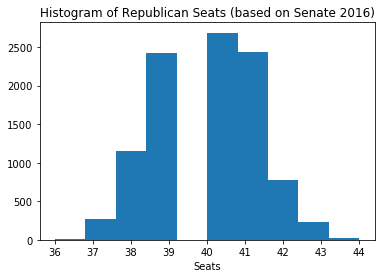

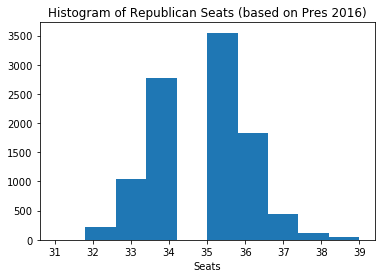

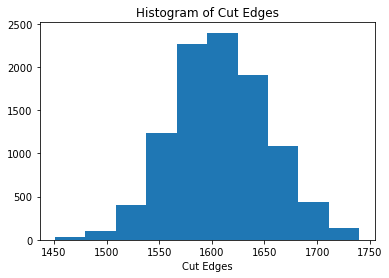

In [34]:


#CHANGE
plt.figure()
plt.hist(CVAP_SENwins_list)
plt.title("Histogram of Republican Seats (based on Senate 2016)")
plt.xlabel("Seats")
#plt.savefig("PA_hist_symmetric_entropy_5000.png")
plt.show()

plt.figure()
plt.hist(CVAP_PRESwins_list)
plt.title("Histogram of Republican Seats (based on Pres 2016)")
plt.xlabel("Seats")
#plt.savefig("PA_hist_symmetric_entropy_5000.png")
plt.show()

plt.figure()
plt.hist(CVAP_cutedges_list)
plt.title("Histogram of Cut Edges")
plt.xlabel("Cut Edges")
#plt.savefig("PA_hist_symmetric_entropy_5000.png")
plt.show()

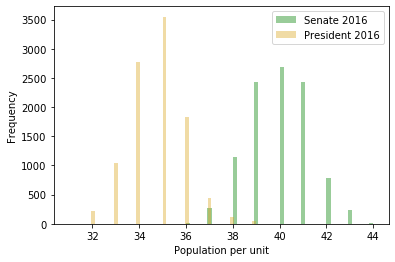

In [35]:
import seaborn as sns

colors = ['green', 'goldenrod']
labels= ['Senate 2016', 'President 2016']
plt.figure()

plt_1 = sns.distplot(CVAP_SENwins_list,kde=False, color=colors[0],label=labels[0])
plt_2 = sns.distplot(CVAP_PRESwins_list, kde=False, color=colors[1],label=labels[1])

plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Population per unit")
plt.show()



## VAP CHAIN

In [36]:
pop_col = "VAP"

elections = [
        Election("PRES16",{"Democratic": "PRES16D","Republican":"PRES16R" }),
        Election("SEN16",{"Democratic": "SEN16D","Republican":"SEN16R" })]

#my_updaters = {"population" : updaters.Tally("TOTPOP", alias="population")}
my_updaters = {"population" : Tally(pop_col, alias="population"),
            "cut_edges": cut_edges}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

tot_pop_col = df['VAP'].sum()


In [37]:
cddict = recursive_tree_part(graph,range(num_districts),tot_pop_col/num_districts,pop_col,0.01,1)

starting_partition = Partition(graph,assignment=cddict,updaters=my_updaters)


In [43]:
proposal = partial(
        recom, pop_col=pop_col, pop_target=tot_pop_col/num_districts, epsilon=0.07, node_repeats=1
    )

compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(starting_partition["cut_edges"])
    )

chain = MarkovChain(
        proposal,
        constraints=[
            constraints.within_percent_of_ideal_population(starting_partition, 0.07),compactness_bound
          #constraints.single_flip_contiguous#no_more_discontiguous
        ],
        accept=accept.always_accept,
        initial_state=starting_partition,
        total_steps=10000
    )


In [44]:
t = 0
VAP_SENwins_list = []
VAP_PRESwins_list = []
VAP_cutedges_list = []
for part in chain:
    VAP_SENwins_list.append(part["SEN16"].wins("Republican"))
    VAP_PRESwins_list.append(part["PRES16"].wins("Republican"))
    VAP_cutedges_list.append(len(part["cut_edges"]))
    t += 1
    if t % 100 == 0:
        print("finished chain " + str(t))
        


finished chain 100
finished chain 200
finished chain 300
finished chain 400
finished chain 500
finished chain 600
finished chain 700
finished chain 800
finished chain 900
finished chain 1000
finished chain 1100
finished chain 1200
finished chain 1300
finished chain 1400
finished chain 1500
finished chain 1600
finished chain 1700
finished chain 1800
finished chain 1900
finished chain 2000
finished chain 2100
finished chain 2200
finished chain 2300
finished chain 2400
finished chain 2500
finished chain 2600
finished chain 2700
finished chain 2800
finished chain 2900
finished chain 3000
finished chain 3100
finished chain 3200
finished chain 3300
finished chain 3400
finished chain 3500
finished chain 3600
finished chain 3700
finished chain 3800
finished chain 3900
finished chain 4000
finished chain 4100
finished chain 4200
finished chain 4300
finished chain 4400
finished chain 4500
finished chain 4600
finished chain 4700
finished chain 4800
finished chain 4900
finished chain 5000
finished 

In [46]:
#  things to change:
#  obj = {"[replace]_based_[replace]" : list(np.array(REPLACE).flatten())}
import json 

outputdir = './data/chain_results_json/'
obj = {"array" : list(VAP_PRESwins_list)}

with open(outputdir+"Senate_VAPchain_PRES16_Rwins.json", 'w') as jf1:
    json.dump(dict(obj), jf1)

In [47]:
#  things to change:
#  obj = {"[replace]_based_[replace]" : list(np.array(REPLACE).flatten())}
import json 

outputdir = './data/chain_results_json/'
obj = {"array" : list(VAP_SENwins_list)}

with open(outputdir+"Senate_VAPchain_SEN16_Rwins.json", 'w') as jf1:
    json.dump(dict(obj), jf1)

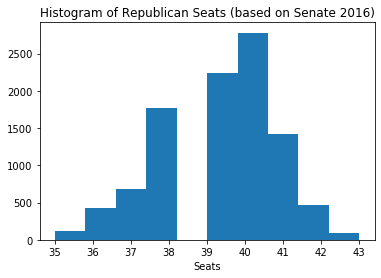

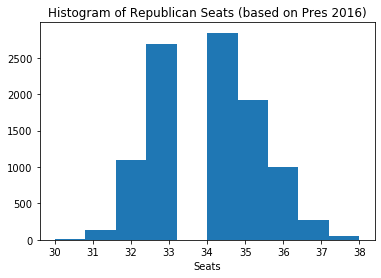

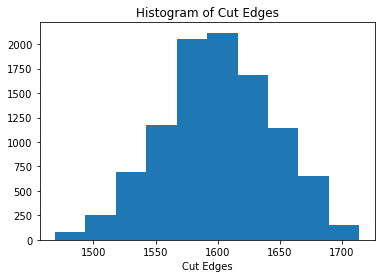

In [48]:


#CHANGE
plt.figure()
plt.hist(VAP_SENwins_list)
plt.title("Histogram of Republican Seats (based on Senate 2016)")
plt.xlabel("Seats")
#plt.savefig("PA_hist_symmetric_entropy_5000.png")
plt.show()

plt.figure()
plt.hist(VAP_PRESwins_list)
plt.title("Histogram of Republican Seats (based on Pres 2016)")
plt.xlabel("Seats")
#plt.savefig("PA_hist_symmetric_entropy_5000.png")
plt.show()

plt.figure()
plt.hist(VAP_cutedges_list)
plt.title("Histogram of Cut Edges")
plt.xlabel("Cut Edges")
#plt.savefig("PA_hist_symmetric_entropy_5000.png")
plt.show()

## Comparison of CVAP/VAP/TOTPOP/CPOP runs

In [49]:
import json

CPOP_PRESwins_data = './data/chain_results_json/Senate_CPOPchain_PRES16_Rwins.json'
CPOP_SENwins_data = './data/chain_results_json/Senate_CPOPchain_SEN16_Rwins.json'
TOTPOP_PRESwins_data = './data/chain_results_json/Senate_TOTPOPchain_PRES16_Rwins.json'
TOTPOP_SENwins_data = './data/chain_results_json/Senate_TOTPOPchain_SEN16_Rwins.json'
#VAP_PRESwins_list
#VAP_SENwins_list
#CVAP_PRESwins_list
#CVAP_SENwins_list

with open(CPOP_PRESwins_data) as f:
    data = json.load(f)
    CPOP_PRESwins_list = data['array']

with open(CPOP_SENwins_data) as f:
    data = json.load(f)
    CPOP_SENwins_list = data['array']
    
with open(TOTPOP_PRESwins_data) as f:
    data = json.load(f)
    TOTPOP_PRESwins_list = data['array']

with open(TOTPOP_SENwins_data) as f:
    data = json.load(f)
    TOTPOP_SENwins_list = data['array']

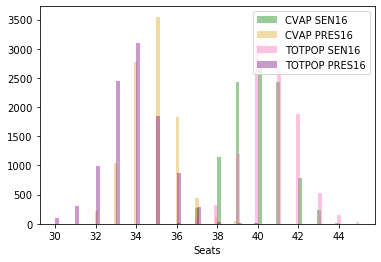

In [61]:
colors = ['green', 'goldenrod', 'hotpink', 'purple']
labels= ['CVAP SEN16', 'CVAP PRES16', 'TOTPOP SEN16', 'TOTPOP PRES16']
plt.figure()

plt_1 = sns.distplot(CVAP_SENwins_list,kde=False, color=colors[0],label=labels[0])
plt_2 = sns.distplot(CVAP_PRESwins_list, kde=False, color=colors[1],label=labels[1])
plt_3 = sns.distplot(TOTPOP_SENwins_list, kde=False, color=colors[2],label=labels[2])
plt_4 = sns.distplot(TOTPOP_PRESwins_list, kde=False, color=colors[3],label=labels[3])

plt.legend()
#plt.ylabel("Frequency")
plt.xlabel("Seats")
plt.show()

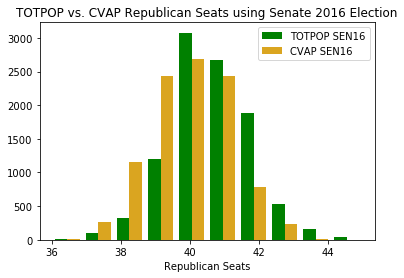

In [66]:
plt.figure()
plt.style.use('seaborn-deep')

colors = ['green', 'goldenrod']
labels= ['TOTPOP SEN16', 'CVAP SEN16']

plt.hist([TOTPOP_SENwins_list, CVAP_SENwins_list],label=labels, color=colors)
plt.legend(loc='upper right')
plt.xlabel("Republican Seats")
plt.title("TOTPOP vs. CVAP Republican Seats using Senate 2016 Election")
plt.show()

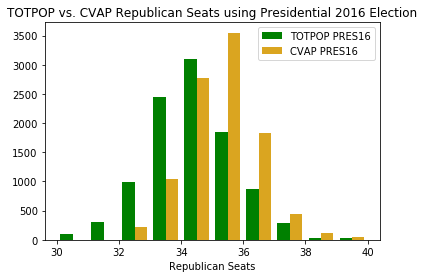

In [67]:
plt.figure()
plt.style.use('seaborn-deep')

colors = ['green', 'goldenrod']
labels= ['TOTPOP PRES16', 'CVAP PRES16']

plt.hist([TOTPOP_PRESwins_list, CVAP_PRESwins_list],label=labels, color=colors)
plt.legend(loc='upper right')
plt.xlabel("Republican Seats")
plt.title("TOTPOP vs. CVAP Republican Seats using Presidential 2016 Election")

plt.show()